# Cluster points and explore boundary *blurriness* with A-DBSCAN 

In [14]:
%matplotlib inline

import pandas
import geopandas
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib.cg.alpha_shapes import alpha_shape_auto

import sys
sys.path.append("../")
from esda.adbscan import ADBSCAN, get_cluster_boundary

## Data

In [3]:
tab = pandas.read_csv("data/berlin-listings.csv")
tab.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,10.0,f,NaN,NaN,t,flexible,f,f,3,2.00
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,1.29


In [4]:
tab.shape

(20053, 96)

In [5]:
tab = tab.sample(n=2000, random_state=1234)

Convert into a `GeoDataFrame`:

In [6]:
db_ll = geopandas.GeoDataFrame(tab,
                               geometry=geopandas.points_from_xy(tab.longitude, tab.latitude),
                               crs={'init': 'epsg:4326'}
                              )

Project it:

In [7]:
db = db_ll.to_crs(epsg=5243)

Voila!

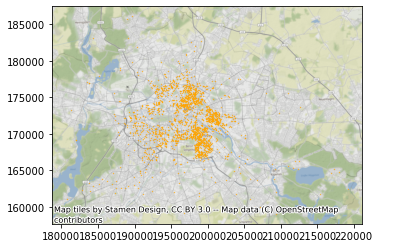

In [8]:
ax = db.plot(markersize=0.1, color='orange')
cx.add_basemap(ax, crs=db.crs);

Add XY coords back to table:

In [9]:
db["X"] = db.geometry.x
db["Y"] = db.geometry.y

## Identify clusters of AirBnb

In [10]:
db.shape[0] * 0.01

20.0

In [125]:
%%time
# Get clusters
adbs = ADBSCAN(500, 20, pct_exact=0.5, reps=10, keep_solus=True)
np.random.seed(1234)
adbs.fit(db)

CPU times: user 700 ms, sys: 90 ms, total: 790 ms
Wall time: 789 ms


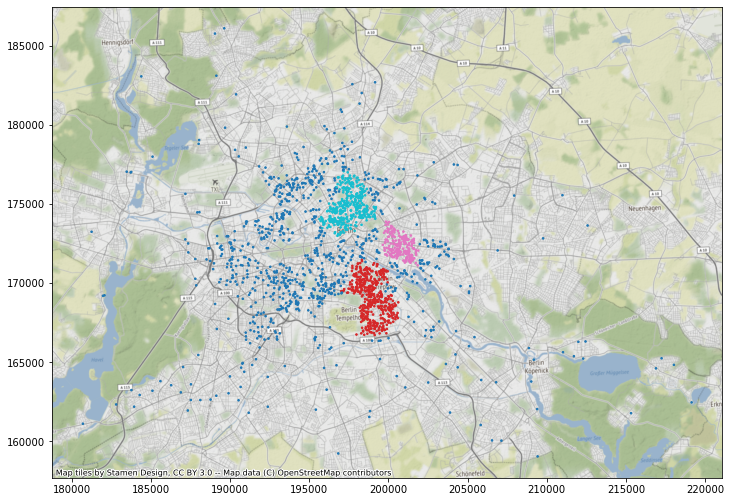

In [126]:
ax = db.assign(lbls=adbs.votes["lbls"])\
       .plot(column="lbls", 
             categorical=True,
             markersize=2.5,
             figsize=(12, 12)
            )
cx.add_basemap(ax, crs=db.crs);

Draw boundary with $\alpha$-shapes:

In [127]:
%time polys = get_cluster_boundary(adbs.votes["lbls"], db, crs=db.crs)

CPU times: user 2.26 s, sys: 20 ms, total: 2.28 s
Wall time: 2.27 s


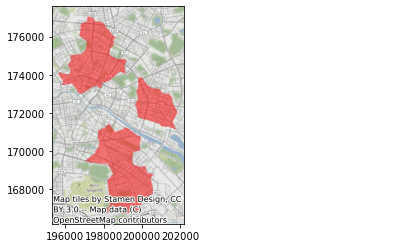

In [128]:
ax = polys.plot(alpha=0.5, color="red")
cx.add_basemap(ax, crs=polys.crs);

And a more zoomed-in view, dimming out areas outside each cluster:

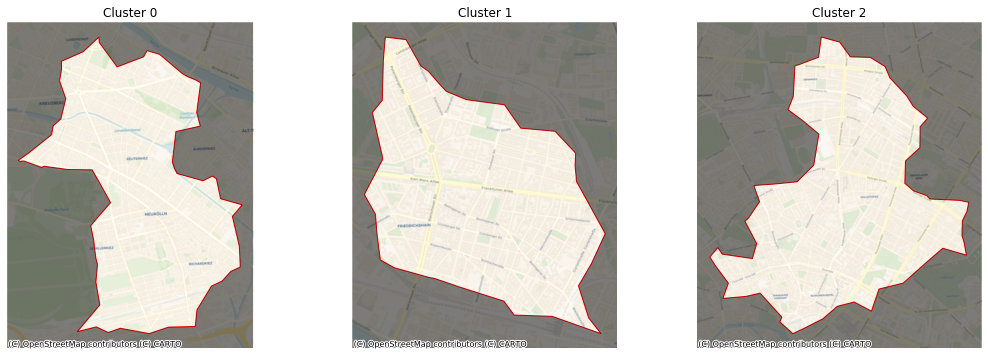

In [129]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    # Plot the boundary of the cluster found
    ax = polys[[i]].plot(ax=ax, 
                         edgecolor="red",
                         facecolor="none"
                        )
    # Add basemap
    cx.add_basemap(ax, 
                   crs=polys.crs, 
                   url=cx.providers.CartoDB.Voyager
                  )
    # Extra to dim non-cluster areas
    (minX, maxX), (minY, maxY) = ax.get_xlim(), ax.get_ylim()
    bb = Polygon([(minX, minY),
                  (maxX, minY),
                  (maxX, maxY),
                  (minX, maxY),
                  (minX, minY)
                 ])
    geopandas.GeoSeries([bb.difference(polys[i])],
                        crs=polys.crs
                       ).plot(ax=ax, 
                              color='k', 
                              alpha=0.5
                             )
    ax.set_axis_off()
    ax.set_title(f"Cluster {polys[[i]].index[0]}")
plt.show()

## Explore boundary *blurriness*

In [130]:
%%time
lines = []
for rep in adbs.solus:
    line = get_cluster_boundary(adbs.solus[rep], 
                                db, 
                                crs=db.crs
                               )
    line = line.boundary
    line = line.reset_index()\
               .rename(columns={0: "geometry", 
                                "index": "cluster_id"}
                      )\
               .assign(rep=rep)
    lines.append(line)
lines = pandas.concat(lines)
lines = geopandas.GeoDataFrame(lines, crs=db.crs)

CPU times: user 20.8 s, sys: 150 ms, total: 20.9 s
Wall time: 20.9 s


In [131]:
lines.head()

,cluster_id,geometry,rep
0,0,LINESTRING (200621.5270901769 168784.816840818...,rep-00
1,1,LINESTRING (202254.2498433599 171209.229568897...,rep-00
2,2,"LINESTRING (197037.9905734365 172632.54675, 19...",rep-00
3,3,LINESTRING (194118.5149434218 169319.717915361...,rep-00
4,4,LINESTRING (196753.9517711732 171244.853505570...,rep-00


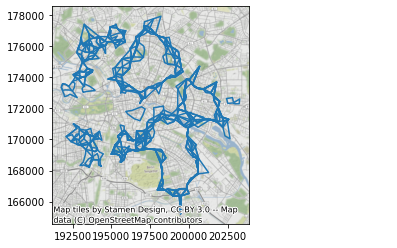

In [132]:
ax = lines.plot()
cx.add_basemap(ax, crs=lines.crs)

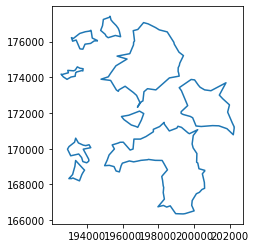

In [133]:
lines.query("rep == 'rep-00'").plot()

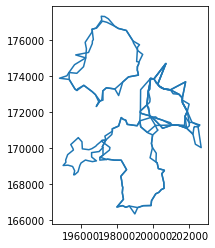

In [136]:
lines.query("cluster_id == '2'").plot()